# Load and preprocess data

Here I load, and do some minimal preprocessing, which I arrived at in the EDA notebook.

In [1]:
import os, time, gc, re 
from collections import deque
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

from sklearn import preprocessing

from googletrans import Translator

%matplotlib inline

In [2]:
def load_sales(parse_date = True):
    data_fol = 'data'
    sales = pd.read_csv(os.path.join(data_fol, 'sales_train.csv'))
    if parse_date:
        date_col = pd.to_datetime(sales.date, format='%d.%m.%Y')
        sales.date = date_col
        sales['Month'] = sales.date.dt.to_period('M')
    return sales

def aggregate_monthly(sales_df):
    assert 'Month' in sales_df.columns, 'Month column not found'
    return (sales_df
            .groupby(['Month', 'shop_id', 'item_id'])
            .agg({'item_cnt_day': np.sum, 'item_price': np.mean})
            .rename(columns={'item_cnt_day':'item_cnt_month'})
           )

In [3]:
def load_all():
    sales = load_sales()
    items = pd.read_csv('data/items.csv')
    categories = pd.read_csv('data/item_categories_expanded.csv')
    shops = pd.read_csv('data/shops_expanded.csv')
    test_set = pd.read_csv('data/test.csv')
    return sales, items, categories, shops, test_set


In [4]:
sales,items, categories, shops, test_set = load_all()

Merge duplicate shops

In [5]:
sales.loc[sales.shop_id==11, 'shop_id'] = 10
sales.loc[sales.shop_id==57, 'shop_id'] = 0
sales.loc[sales.shop_id==58, 'shop_id'] = 1

drop shops with insufficient data

In [6]:
sales = sales[~sales.shop_id.isin([0,1, 8 ,11, 13, 23, 29, 30, 32, 33,  36])]

In [7]:
le = preprocessing.LabelEncoder()

In [8]:
categories.category_type = le.fit_transform(categories.category_type)

In [9]:
shops.city = le.fit_transform(shops.city)
shops.shop_type = le.fit_transform(shops.shop_type)

In [10]:
sales.shape

(2589881, 7)

In [11]:
sales = sales[sales.item_price<100000]
sales = sales[sales.item_cnt_day<1001]

In [12]:
sales.shape

(2589879, 7)

In [13]:
agg_sales = aggregate_monthly(sales)

In [14]:
def create_submission_like_df():
    months = sorted(agg_sales.index.levels[0])
    submission_like_data  = {}
    for month in months:    
        month_data = agg_sales.loc[month]
        shops = set(month_data.index.get_level_values(0))
        item_ids = set(month_data.index.get_level_values(1))

        new_idx = pd.Index(product(shops, item_ids), name=month_data.index.name)
        submission_like_data[month] = month_data.reindex(new_idx).fillna({'item_cnt_month':0, 'item_price':-1})
        
    submission_like_df = pd.concat(submission_like_data)
    submission_like_df.index.names = agg_sales.index.names
    
    return submission_like_df

In [21]:
# agg_sales = agg_sales.drop(6066, level=2)

In [22]:
agg_sales.loc[agg_sales.item_price <= 0.1, 'item_price'] = np.nan
agg_sales['item_price'] = agg_sales.groupby(level=2).item_price.transform(lambda x: x.fillna(x.mean()))

In [23]:
cat_annotated_agg_sales = (pd.merge(agg_sales.reset_index(), items.drop('item_name', axis=1), on='item_id')
                           .set_index(['Month', 'shop_id', 'item_id'])
                           .sort_index(level=[0,1,2])
                          )

In [24]:
submission_like_df = create_submission_like_df()

In [25]:
months = sorted(agg_sales.index.levels[0])

In [26]:
model1_oos_predictions = pd.read_pickle('EN_model_predictions.p')

<hr>
<hr>
<hr>

# Built-out XGB Model

## Feature Generation

In [27]:
piv_agg_sales = agg_sales.item_cnt_month.unstack(level=0).fillna(0).sort_index()

Reduce data foot print

In [28]:
piv_agg_sales = piv_agg_sales.astype(int)

In [29]:
preprocessed_data = piv_agg_sales

### Sales Moving Averages

In [30]:
half_lifes = [1,2,3,6,9,12]

In [31]:
%%time
sales_ewms_mean = {tau:preprocessed_data.ewm(halflife=tau, axis=1, min_periods=tau).mean().astype(np.float32) for tau in half_lifes}
sales_ewms_std = {tau:preprocessed_data.ewm(halflife=tau, axis=1, min_periods=tau).std().astype(np.float32) for tau in half_lifes}

Wall time: 28.4 s


In [32]:
%%time
prices = agg_sales.item_price.unstack(level=0).fillna(0)
shop_monthly_income = (prices*preprocessed_data).groupby(level=0).transform('sum')
item_monthly_income = (prices*preprocessed_data).groupby(level=1).transform('sum')
items_income_ewms = {tau:item_monthly_income.ewm(halflife=tau, axis=1, min_periods=tau).mean().astype(np.float32) for tau in half_lifes}
shops_income_ewms = {tau:shop_monthly_income.ewm(halflife=tau, axis=1, min_periods=tau).mean().astype(np.float32) for tau in half_lifes}

Wall time: 26.3 s


Relative change in shop profit

In [33]:
shop_income_rmean = shop_monthly_income.rolling(window=12, axis=1).mean()

In [34]:
shop_income_trend = (shop_monthly_income - shop_income_rmean)/shop_monthly_income
diff_shop_income_trend = shop_income_trend.diff(axis=1)

In [35]:
del(prices, shop_monthly_income, item_monthly_income, shop_income_rmean)

### Rolling stats

In [36]:
windows = [3,6,9,12]

In [37]:
%%time
sales_rmin = {w:preprocessed_data.rolling(window=w, axis=1).min().astype(np.float32) for w in windows}
sales_rmedian = {w:preprocessed_data.rolling(window=w, axis=1).median().astype(np.float32) for w in windows}
sales_rmax = {w:preprocessed_data.rolling(window=w, axis=1).max().astype(np.float32) for w in windows}

Wall time: 2min 6s


### Mean Encode Shops

In [38]:
%%time
target_encode_shops_itemCounts = preprocessed_data.groupby(level=0).transform('sum')
target_encode_shops_uniqueItems = preprocessed_data.groupby(level=0).transform(lambda x: (x>0).sum())
#target_encode_shops_soldAnything = target_encode_shops_uniqueItems.astype(bool).astype(int)

targenc_shops_itemCounts_ewms = {tau:target_encode_shops_itemCounts.ewm(halflife=tau, axis=1, min_periods=tau).mean().astype(np.float32) for tau in half_lifes}
targenc_shops_uniqueItems_ewms = {tau:target_encode_shops_uniqueItems.ewm(halflife=tau, axis=1, min_periods=tau).mean().astype(np.float32) for tau in half_lifes}
#target_encode_shops_soldAnything_ewms = {tau:target_encode_shops_soldAnything.ewm(halflife=tau, axis=1, min_periods=tau).mean().astype(np.float32) for tau in half_lifes}

del(target_encode_shops_itemCounts, target_encode_shops_uniqueItems)

Wall time: 25.6 s


### Encode Items

First item map to category, and encode how many items in that category sold that month

In [39]:
cat_sales = cat_annotated_agg_sales.groupby(['Month','item_category_id']).item_cnt_month.transform('sum')
cat_sales = cat_sales.unstack(level=0).fillna(0)
targenc_cat_sales = {tau:cat_sales.ewm(halflife=tau, axis=1, min_periods=tau).mean().astype(np.float32) for tau in half_lifes}

In [40]:
did_item_sell_that_month = piv_agg_sales.groupby('item_id').transform('max').astype(bool).astype(int)
sales_bool_rsum = {w:did_item_sell_that_month.rolling(window=w, axis=1).sum().astype(np.float32) for w in windows}

In [41]:
target_encode_items_totalMonthCounts = preprocessed_data.groupby(level=1).transform('sum')
targenc_items_totalMonthCounts_ewms = {tau:target_encode_items_totalMonthCounts.ewm(halflife=tau, axis=1, min_periods=tau).mean().astype(np.float32) for tau in half_lifes}

In [42]:
del(cat_sales, did_item_sell_that_month, target_encode_items_totalMonthCounts)

### Price related features

Does price end in 9?

In [43]:
# endsIn9 = agg_sales.item_price.transform(lambda x: x%10 == 9).unstack(level=0).fillna(False).reindex(preprocessed_data.index)

relative change in item price (relative to 12 month moving average)

In [44]:
piv_agg_prices = agg_sales.item_price.unstack(level=0)
mean_item_price = piv_agg_prices.groupby(level=1).mean()
rmean_item_price = mean_item_price.rolling(12, axis=1).mean()
item_relative_price_change = (mean_item_price - rmean_item_price)/rmean_item_price

Conform to data set

In [45]:
rel_stacked = item_relative_price_change.stack()
preprocessed_stacked = preprocessed_data.stack().reset_index('shop_id')

In [46]:
%%time
rel_stacked_reindexed = rel_stacked.reindex(preprocessed_stacked.index)

Wall time: 29.6 s


In [47]:
preprocessed_stacked['relPrice'] = rel_stacked_reindexed
relPrice = preprocessed_stacked.set_index('shop_id', append=True).relPrice.unstack('Month')
relPrice = relPrice.swaplevel(0,1).sort_index()
diff_relPrice = relPrice.diff(axis=1)

In [48]:
relPrice.head()

Month            2013-01  2013-02  2013-03  2013-04  2013-05  2013-06  \
shop_id item_id                                                         
2       27           NaN      NaN      NaN      NaN      NaN      NaN   
        30           NaN      NaN      NaN      NaN      NaN      NaN   
        31           NaN      NaN      NaN      NaN      NaN      NaN   
        32           NaN      NaN      NaN      NaN      NaN      NaN   
        33           NaN      NaN      NaN      NaN      NaN      NaN   

Month            2013-07  2013-08  2013-09  2013-10  ...   2015-01   2015-02  \
shop_id item_id                                      ...                       
2       27           NaN      NaN      NaN      NaN  ...       NaN       NaN   
        30           NaN      NaN      NaN      NaN  ...  0.012074  0.009946   
        31           NaN      NaN      NaN      NaN  ... -0.107836 -0.067712   
        32           NaN      NaN      NaN      NaN  ... -0.028209 -0.014316   
        33           NaN      NaN      NaN      NaN  ...  0.006559  0.005176   

Month             2015-03   2015-04   2015-05   2015-06   2015-07   2015-08  \
shop_id item_id                                                               
2       27            NaN       NaN       NaN       NaN       NaN       NaN   
        30       0.009946  0.007021  0.004335 -0.217884 -0.204940 -0.188264   
        31      -0.005690 -0.039881 -0.064654 -0.132894 -0.023914 -0.480326   
        32      -0.001276  0.026540  0.026540  0.026540  0.016939  0.014150   
        33      -0.023627  0.006727  0.005429  0.005429 -0.020090  0.007340   

Month             2015-09   2015-10  
shop_id item_id                      
2       27            NaN       NaN  
        30      -0.231028 -0.148057  
        31      -0.499868  0.007444  
        32       0.012920  0.012918  
        33      -0.006875 -0.008265  

[5 rows x 34 columns]

Repeat but for item revenue

In [49]:
piv_agg_revenues = (agg_sales.item_price * agg_sales.item_cnt_month).unstack(level=0)
mean_item_revenues = piv_agg_revenues.groupby(level=1).mean()
rmean_item_revenues = mean_item_revenues.rolling(12, axis=1).mean()
item_relative_revenue_change = (mean_item_revenues - rmean_item_revenues)/rmean_item_revenues

In [50]:
%%time
rel_rev_stacked = item_relative_revenue_change.stack()
preprocessed_stacked = preprocessed_data.stack().reset_index('shop_id')
rel_rev_reindexed = rel_rev_stacked.reindex(preprocessed_stacked.index)

Wall time: 34 s


In [51]:
preprocessed_stacked['relRev'] = rel_rev_reindexed
relRev = preprocessed_stacked.set_index('shop_id', append=True).relRev.unstack('Month')
relRev = relRev.swaplevel(0,1).sort_index()
diff_relRev = relRev.diff(axis=1)

In [52]:
del(piv_agg_prices, mean_item_price, rmean_item_price, item_relative_price_change, rel_stacked, preprocessed_stacked, rel_stacked_reindexed)

In [53]:
del(piv_agg_revenues, mean_item_revenues, rmean_item_revenues, item_relative_revenue_change, rel_rev_stacked, rel_rev_reindexed)

In [54]:
gc.collect()

0

### Date Related features

In [55]:
import calendar

In [56]:
extended_months = months+[pd.Period('2015-11')]
hols2013 = [8,2,2,0,7,3,1,2,2,1,2,3]
hols2014 = [10,3,4,1,8,7,2,0,2,2,4,1]
hols2015 = [11,3,3,1,5,3,2,0,3,1,1,2]
holidadys = hols2013 + hols2014 + hols2015
month_holidays = dict(zip(extended_months, holidadys))

In [57]:
vals = {}
for mon in extended_months:
    cal = calendar.monthcalendar(mon.year, mon.month)
    total_days = (np.array(cal).flatten() != 0).sum()
    num_mondays = sum([1 for week in cal if week[0] != 0])
    num_tuesdays = sum([1 for week in cal if week[1] != 0])
    num_wednesdays = sum([1 for week in cal if week[2] != 0])
    num_thursdays = sum([1 for week in cal if week[3] != 0])
    num_fridays = sum([1 for week in cal if week[4] != 0])
    num_saturdays = sum([1 for week in cal if week[5] != 0])
    num_sundays = sum([1 for week in cal if week[6] != 0])
    vals[mon] = pd.Series({'total_days': total_days, 'mondays':num_mondays, 'tuesdays':num_tuesdays, 'wednesdays':num_wednesdays, 'thursdays':num_thursdays, 'fridays':num_fridays, 'saturdays':num_saturdays, 'sundays':num_sundays})

In [58]:
month_decomp = pd.concat([pd.concat(vals, axis=1).T, pd.Series(month_holidays, name='holidays')], axis=1)
month_decomp['num_weekends'] = month_decomp[['saturdays', 'sundays']].sum(axis=1)
month_decomp['num_weekdays'] = month_decomp.total_days - month_decomp.num_weekends

In [59]:
month_decomp = month_decomp.astype(np.int32)

In [60]:
month_decomp = month_decomp.drop(['mondays', 'tuesdays', 'wednesdays' ,'thursdays', 'fridays', 'saturdays', 'sundays'], axis=1)

In [61]:
month_decomp.head()

,total_days,holidays,num_weekends,num_weekdays
2013-01,31,8,8,23
2013-02,28,2,8,20
2013-03,31,2,10,21
2013-04,30,0,8,22
2013-05,31,7,8,23


### Advanced Features - KMeans

In [62]:
from sklearn.cluster import KMeans

Note that I am using the entire data set to find the groups - this means that there is some future peaking. But I will use only causal data to obtain the features, so it shouldn't be too bad.

In [63]:
shop_cat = cat_annotated_agg_sales.reset_index().groupby(['shop_id', 'item_category_id']).item_cnt_month.sum().unstack(level=1).fillna(0)

In [64]:
kmeans = KMeans(n_clusters=3).fit(shop_cat)

In [65]:
pd.Series(kmeans.labels_).value_counts()

2    30
0    13
1     4
dtype: int64

In [66]:
shop_id_map = dict(zip(shop_cat.index, kmeans.labels_))
kmeans_idx = piv_agg_sales.index.get_level_values(0).map(shop_id_map)

In [67]:
kgrouped = piv_agg_sales.groupby([kmeans_idx, piv_agg_sales.index.get_level_values(1)])
kgrouped_means = kgrouped.transform('mean')
kgrouped_stds = kgrouped.transform('std').fillna(0)
kgrouped_meds = kgrouped.transform('median')

In [68]:
kgrouped_means_ewms = {tau:kgrouped_means.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}
kgrouped_stds_ewms = {tau:kgrouped_stds.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}
kgrouped_meds_ewms = {tau:kgrouped_meds.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}

In [69]:
del(shop_cat, kgrouped, kgrouped_means, kgrouped_stds, kgrouped_meds)

### Advanced Features - interaction

Shop-Category

Idea here is to create a feature that captures the interaction between shop and category, and then do a mean encoding. But I will do both in one step by simply grouping by shop $\times$ category

In [70]:
item_cat_map = items.set_index('item_id').item_category_id
cat_idx = piv_agg_sales.index.get_level_values('item_id').map(item_cat_map)

In [71]:
%%time
shop_cat_mean = piv_agg_sales.groupby([piv_agg_sales.index.get_level_values('shop_id'), cat_idx]).transform('mean')
shop_cat_std = piv_agg_sales.groupby([piv_agg_sales.index.get_level_values('shop_id'), cat_idx]).transform('std').fillna(0)
#shop_cat_med = piv_agg_sales.groupby([piv_agg_sales.index.get_level_values('shop_id'), cat_idx]).transform('median')

Wall time: 1.19 s


In [72]:
%%time
shopcat_means_ewms = {tau:shop_cat_mean.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}
shopcat_stds_ewms = {tau:shop_cat_std.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}
#shopcat_meds_ewms = {tau:shop_cat_med.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}

Wall time: 26.3 s


shop_type - category_type

TODO

In [73]:
del(shop_cat_mean, shop_cat_std)

###  Advanced Features - Month-Category Interaction

Similar to above, I create a feature capturing the interaction between item category and month. For each category and month combination I gather some statistics, based of target variable (sales). Then I create moving averages of these stats.

In [74]:
cat_idx

Int64Index([19, 40, 37, 40, 37, 57, 57, 37, 40, 49,
            ...
            38, 37, 37, 40, 37, 37, 37, 40, 37, 49],
           dtype='int64', name='item_id', length=364509)

In [75]:
cat_month_sum = piv_agg_sales.groupby(cat_idx).transform('sum')
cat_month_mean = piv_agg_sales.groupby(cat_idx).transform('mean')
cat_month_std = piv_agg_sales.groupby(cat_idx).transform('std').fillna(0)

In [76]:
%%time
catmonth_sum_ewms = {tau:cat_month_sum.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}
catmonth_mean_ewms = {tau:cat_month_mean.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}
catmonth_std_ewms = {tau:cat_month_std.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}

Wall time: 38.2 s


In [77]:
del(cat_idx, cat_month_sum, cat_month_mean,cat_month_std)

### Model Stacking - use Out Sample Pred of Linear Model

In [78]:
model1_oos_predictions = model1_oos_predictions.reset_index()

In [79]:
model1_oos_predictions['Month'] = model1_oos_predictions['Month'].map(dict(zip(months[1:] + [pd.Period('2015-11')], months)))

In [80]:
stacked_preds = model1_oos_predictions.set_index(['Month', 'shop_id', 'item_id']).Pred1.unstack(level=0).reindex(piv_agg_sales.index).fillna(0)

### Creating Objective

In [81]:
# Note that I use raw-data for objective 
objectives = piv_agg_sales.shift(-1, axis=1)

### Putting Features together and adding date features

In [82]:
sales_mean_features = {f'sales_ewms_mean_ewms{tau}': sales_ewms_mean[tau] for tau in half_lifes}
sales_std_features = {f'sales_ewms_std_ewms{tau}': sales_ewms_std[tau] for tau in half_lifes}

items_income_features = {f'items_income_ewms{tau}': items_income_ewms[tau] for tau in half_lifes}
shops_income_features = {f'shops_income_ewms{tau}': shops_income_ewms[tau] for tau in half_lifes}

sales_rmin_features = {f'sales_rmin{w}':sales_rmin[w] for w in windows}
sales_rmedian_features = {f'sales_rmed{w}':sales_rmedian[w] for w in windows}
sales_rmax_features = {f'sales_rmax{w}':sales_rmax[w] for w in windows}

targenc_shops_itemCounts_feats = {f'targenc_shops_itmCnts_ewms{tau}':targenc_shops_itemCounts_ewms[tau] for tau in half_lifes}
targenc_shops_uniqueItems_feats = {f'targenc_shops_uniqItms_ewms{tau}':targenc_shops_uniqueItems_ewms[tau] for tau in half_lifes}
#targenc_shops_soldAnything_ewms = {f'targenc_shops_soldAnything_ewms{tau}':target_encode_shops_soldAnything_ewms[tau] for tau in half_lifes}

targenc_cat_sales_feats = {f'targenc_items_catMonthSales_ewms{tau}':targenc_cat_sales[tau] for tau in half_lifes}
sales_bool_rsum_feats = {f'targenc_items_boolMonthSales_rsum{w}':sales_bool_rsum[w] for w in windows}
targenc_items_totalMonthCounts_ewms_feats = {f'targenc_items_totalMnthCnt_ewms{tau}':targenc_items_totalMonthCounts_ewms[tau] for tau in half_lifes}

kgrouped_means_feats = {f'kgrp_mean_ewms{tau}':kgrouped_means_ewms[tau] for tau in half_lifes}
kgrouped_stds_feats = {f'kgrp_stds_ewms{tau}':kgrouped_stds_ewms[tau] for tau in half_lifes}
kgrouped_meds_feats = {f'kgrp_meds_ewms{tau}':kgrouped_meds_ewms[tau] for tau in half_lifes}

shopcat_means_feats = {f'shopcat_mean_ewms{tau}':shopcat_means_ewms[tau] for tau in half_lifes}
shopcat_stds_feats = {f'shopcat_stds_ewms{tau}':shopcat_stds_ewms[tau] for tau in half_lifes}
#shopcat_meds_feats = {f'shopcat_meds_ewms{tau}':shopcat_meds_ewms[tau] for tau in half_lifes}

catmonth_sum_feats = {f'catmonth_sum_ewms{tau}':catmonth_sum_ewms[tau] for tau in half_lifes}
catmonth_mean_feats = {f'catmonth_mean_ewms{tau}':catmonth_mean_ewms[tau] for tau in half_lifes}
catmonth_std_feats = {f'catmonth_std_ewms{tau}':catmonth_std_ewms[tau] for tau in half_lifes}

features_dict = {**sales_mean_features, **sales_std_features,
                 **items_income_features, **shops_income_features,
                 **sales_rmin_features, **sales_rmedian_features, **sales_rmax_features,
                 **targenc_shops_itemCounts_feats, **targenc_shops_uniqueItems_feats, #**targenc_shops_soldAnything_ewms,
                 **targenc_cat_sales_feats, **sales_bool_rsum_feats, **targenc_items_totalMonthCounts_ewms_feats,
                 **kgrouped_means_feats, **kgrouped_stds_feats, **kgrouped_meds_feats,
                 **shopcat_means_feats, **shopcat_stds_feats, #**shopcat_meds_feats,
                 **catmonth_sum_feats, **catmonth_mean_feats, **catmonth_std_feats,
                }

#features_dict['PriceEndsIn9'] = endsIn9
features_dict['STACKED_preds'] = stacked_preds
features_dict['relPrice'] = relPrice
features_dict['drelPrice'] = diff_relPrice
features_dict['relRevenue'] = relRev
features_dict['drelRevenue'] = diff_relRev
features_dict['shop_relIncome'] = shop_income_trend
features_dict['dshop_relIncome'] = diff_shop_income_trend

Helper function to get features for a single month of data

<hr>
<hr>
<hr>

In [83]:
all_months = preprocessed_data.columns.tolist()
obj_month_map = dict(zip(all_months[:-1], all_months[1:]))

def get_single_month_XY(month_, drop_cols = None, reindex_to_sub=False, num_lagged_values=0):
    cols = [df[month_].rename(name) for (name, df) in features_dict.items()]
    X = pd.concat(cols, axis=1)
    Y = objectives[month_]
    try:
        submission_Y = submission_like_df.item_cnt_month.loc[obj_month_map[month_]]
    except KeyError:
        submission_Y = None
    if (submission_Y is not None) and reindex_to_sub:
        X = X.reindex(submission_Y.index)
        Y = Y.reindex(submission_Y.index).fillna(0)
    
    if num_lagged_values > 0:
        idx = np.argmax(preprocessed_data.columns == month_)
        assert idx >= num_lagged_values, "do not have enough columns for desired lags"
        lagged_vals = preprocessed_data.iloc[:,idx-num_lagged_values:idx]
        lagged_vals.columns = [f'lag{lag}' for lag in list(range(1,num_lagged_values+1))[::-1]]
        X = pd.concat([X,lagged_vals], axis=1)
    
    # might turn this into separate function to pass into here
    X['shop_city'] = X.index.get_level_values('shop_id').map(shops.city)
    X['shop_type'] = X.index.get_level_values('shop_id').map(shops.shop_type)
    X['category_type'] = X.index.get_level_values('item_id').map(items.item_category_id).map(categories.category_type)
    X['month'] = month_.month
    X['season'] = X.month.map({1:0, 2:0, 3:0, 4:1, 5:1, 6:1, 7:1, 8:2, 9:2, 10:2, 11:3, 12:3})
    #X['winter'] = X.month.map({**dict(zip([4,5,6,7,8,9,10], [False]*7)), **dict(zip([1,2,3,11,12], [True]*5))})
    # add more date related features
    current_vals = month_decomp.loc[month_].values
    next_month_vals = month_decomp.shift(-1).loc[month_].astype(int).values
    broadcast_mask = np.ones(X.shape[0], dtype=int)[:,None]
    current_vals = pd.DataFrame(current_vals[None,:] * broadcast_mask, index=X.index, columns=month_decomp.columns)
    next_month_vals = pd.DataFrame(next_month_vals[None,:] * broadcast_mask, index=X.index, columns=['nm_'+col for col in month_decomp.columns])
    X = pd.concat([X, current_vals, next_month_vals], axis=1)
    
    
    if drop_cols is not None:
        X = X.drop(drop_cols, axis=1)
    
    X = pd.concat([X], keys=[month_], names=['Period'])
    Y = pd.concat([Y], keys=[month_], names=['Period'])
    if submission_Y is not None:
        submission_Y = pd.concat([submission_Y], keys=[month_], names=['Period'])
        
    assert X.index.equals(Y.index)    
    
    return X,Y, submission_Y

In [84]:
%%time
X,Y, _ = get_single_month_XY(all_months[-2], reindex_to_sub=True)

Wall time: 2.16 s


In [85]:
X.shape

(219596, 132)

In [86]:
X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 219596 entries, (Period('2015-09', 'M'), 2, 8192) to (Period('2015-09', 'M'), 59, 8189)
Columns: 132 entries, sales_ewms_mean_ewms1 to nm_num_weekdays
dtypes: float32(112), float64(7), int32(8), int64(5)
memory usage: 121.6 MB


In [87]:
del([agg_sales, cal, calendar, cat_annotated_agg_sales])
del([extended_months, holidadys, hols2013, hols2014, hols2015, item_cat_map, mon, month_holidays])
del([num_mondays, num_tuesdays, num_wednesdays, num_thursdays, num_fridays, num_saturdays, num_sundays])
del([piv_agg_sales, preprocessed_data, sales])

In [88]:
gc.collect()

0

## Train on Single Month data

In [89]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [90]:
def fit_and_predict(model, x_train, y_train, x_val = None):
    
    start_time = time.time()
    fitted_model = model.fit(x_train, y_train)
    fit_time = time.time() - start_time
    fitted_model.col_names = x_train.columns
    
    y_train_pred = fitted_model.predict(x_train)
    
    if x_val is not None:
        y_val_pred = fitted_model.predict(x_val)
    else:
        y_val_pred = None
        
    return fitted_model, y_train_pred, y_val_pred, fit_time

In [91]:
def plot_feature_importances(mod, figsize=None, top_n=None):
    plt.figure(figsize=figsize)
    importances = mod.feature_importances_
    if type(importances) == pd.Series:
        ser = importances.sort_values()
    else:
        ser = pd.Series(importances, index=mod.col_names).sort_values()
    if top_n is not None:
        ser = ser.iloc[-top_n:]
    ser.plot(kind='barh')


In [92]:
def conform_to_subY(x, y_pred, y_sub_ser, fill_value=0):
    y_pred_ser = pd.Series(y_pred, index=x.index)
    y_pred_ser = y_pred_ser.reindex(y_sub_ser.index).fillna(0)
    return y_pred_ser
    

In [93]:
%%time
X_train, Y_train, Y_sub = get_single_month_XY(months[15])

Wall time: 1.65 s


In [94]:
X_train.shape

(364509, 132)

In [95]:
import xgboost as xgb

class xgb_model:
    def __init__(self, num_boost_round, **params):
        self.params = {
            'max_depth':6,
            'min_child_weight': 1,
            'eta':.3,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'lambda':1,
            'gamma':0.1,
            'objective':'reg:squarederror',
            # leave nthread default - detects all cores automatically
        }
        self.params.update(params)
        self.fitted_model = None
        self.num_boost_round = num_boost_round
       
    def fit(self, X, Y):
        dm_train = xgb.DMatrix(X,Y)
        self.fitted_model = xgb.train(self.params, dtrain=dm_train, num_boost_round=self.num_boost_round)
        return self
    
    def predict(self, X):
        assert self.fitted_model is not None, 'Must fit first'
        dm = xgb.DMatrix(X)
        return self.fitted_model.predict(dm)
    
    @property
    def feature_importances_(self):
        return pd.Series(self.fitted_model.get_score(importance_type='weight'))

## Rolling Cross Validation

In [96]:
class results:
    def __init__(self, model, fitted_models, preSub_is_scores, preSub_oos_scores, is_scores, os_scores, times=None):
        self.model = model
        self.fitted_models = fitted_models
        self.preSub_is_scores = preSub_is_scores
        self.preSub_oos_scores = preSub_oos_scores
        self.is_scores = is_scores
        self.os_scores = os_scores
        self.times = times
        
    @property
    def keys(self):
        return sorted(self.fitted_models.keys())
        
    @property
    def scores(self):
        return pd.concat([pd.Series(self.preSub_is_scores, name='PreInSampleRMSE'), pd.Series(self.is_scores, name='inSampleRMSE'), pd.Series(self.preSub_oos_scores, name='PreOutSampleRMSE'), pd.Series(self.os_scores, name='outSampleRMSE')], axis=1)
        

In [97]:
def rolling_cross_validation(model, data_months_list, post_process_preds = None, num_lagged_values=12, validate_months_num=None, num_stack_months=1, pred_fill_value=0, fit_final=False, drop_cols=None, reindex_to_sub = False, clip_obj_tuple=None):
    if post_process_preds is None:
        post_process_preds = lambda x: x
        
    Xs_deque = deque()
    Ys_deque = deque()
    Ysubs_deque = deque()
    
    for month in data_months_list[:num_stack_months]:
        X_, Y_, Ysub_= get_single_month_XY(month, drop_cols=drop_cols, num_lagged_values=num_lagged_values, reindex_to_sub=reindex_to_sub)
        Xs_deque.append(X_)
        Ys_deque.append(Y_)
        Ysubs_deque.append(Ysub_)
        
           
    max_validate_months = len(data_months_list) - num_stack_months - 1
    if validate_months_num is None:
        validate_months_num = max_validate_months
    else:
        validate_months_num = min(validate_months_num, max_validate_months)
        
    
    fitted_models = {}
    in_sample_scores = {}
    oos_scores = {}
    prepred_is_scores = {}
    prepred_os_scores = {}
    loop_times = []
    
    
    for month in data_months_list[num_stack_months: num_stack_months + validate_months_num]:
        print(f'Working on: {month}')
        loop_start = time.time()
        
        X_train = pd.concat(Xs_deque)
        Y_train = pd.concat(Ys_deque)
        Y_sub_train = pd.concat(Ysubs_deque)
        
        if clip_obj_tuple is not None:
            Y_train = Y_train.clip(*clip_obj_tuple)
        
        X_val, Y_val, Y_sub_val = get_single_month_XY(month, drop_cols=drop_cols, num_lagged_values=num_lagged_values, reindex_to_sub=reindex_to_sub)
        fitted, ytrain_pred, yval_pred, elapsed_time = fit_and_predict(model, X_train, Y_train, X_val)
        fitted_models[month] = fitted
        print(f'fit time: {elapsed_time}')
        
        prepred_is_scores[month] = np.sqrt(mean_squared_error(Y_train, ytrain_pred))
        prepred_os_scores[month] = np.sqrt(mean_squared_error(Y_val, yval_pred))
        
        ytrain_pred = conform_to_subY(X_train, ytrain_pred, Y_sub_train, fill_value=pred_fill_value)
        yval_pred = conform_to_subY(X_val, yval_pred, Y_sub_val, fill_value=pred_fill_value)
        
        ytrain_pred = post_process_preds(ytrain_pred)
        yval_pred = post_process_preds(yval_pred)
        
        in_sample_scores[month] = np.sqrt(mean_squared_error(Y_sub_train, ytrain_pred))
        oos_scores[month] = np.sqrt(mean_squared_error(Y_sub_val, yval_pred))
        
        Xs_deque.popleft()
        Ys_deque.popleft()
        Ysubs_deque.popleft()
        
        Xs_deque.append(X_val)
        Ys_deque.append(Y_val)
        Ysubs_deque.append(Y_sub_val)

        
        loop_end = time.time()
        loop_times.append(loop_end - loop_start)
        
    
    if fit_final:
        X_train = pd.concat(Xs_deque)
        Y_train = pd.concat(Ys_deque)
        Y_sub_train = pd.concat(Ysubs_deque)
        
        if clip_obj_tuple is not None:
            Y_train = Y_train.clip(*clip_obj_tuple)
        
        fitted, ytrain_pred, yval_pred, elapsed_time = fit_and_predict(model, X_train, Y_train, X_val)
        fitted_models['FINAL'] = fitted
        prepred_is_scores['FINAL'] = np.sqrt(mean_squared_error(Y_train, ytrain_pred))
        ytrain_pred = conform_to_subY(X_train, ytrain_pred, Y_sub_train, fill_value=pred_fill_value)
        ytrain_pred = post_process_preds(ytrain_pred)
        in_sample_scores['FINAL'] = np.sqrt(mean_squared_error(Y_sub_train, ytrain_pred))
    
    return results(model, fitted_models, prepred_is_scores, prepred_os_scores, in_sample_scores, oos_scores, loop_times)

## Try lightGBM

In [113]:
Xs_deque = deque()
Ys_deque = deque()
Ysubs_deque = deque()

for month in months[13:-1]:
    X_, Y_, Ysub_= get_single_month_XY(month, drop_cols=None, num_lagged_values=0, reindex_to_sub=True)
    Xs_deque.append(X_)
    Ys_deque.append(Y_)
    Ysubs_deque.append(Ysub_)

In [114]:
X_train = pd.concat(Xs_deque)
Y_train = pd.concat(Ys_deque)
Y_sub_train = pd.concat(Ysubs_deque)

In [115]:
X_train

sales_ewms_mean_ewms1  sales_ewms_mean_ewms2  \
Period  shop_id item_id                                                 
2014-02 2       27                    0.000061               0.003262   
                28                         NaN                    NaN   
                29                         NaN                    NaN   
                30                    0.002197               0.024973   
                31                    0.001221               0.034198   
...                                        ...                    ...   
2015-09 59      8178                       NaN                    NaN   
                8180                       NaN                    NaN   
                8184                       NaN                    NaN   
                8187                       NaN                    NaN   
                8189                       NaN                    NaN   

                         sales_ewms_mean_ewms3  sales_ewms_mean_ewms6  \
Period  shop_id item_id                                                 
2014-02 2       27                    0.010653               0.030315   
                28                         NaN                    NaN   
                29                         NaN                    NaN   
                30                    0.050733               0.092209   
                31                    0.091906               0.217174   
...                                        ...                    ...   
2015-09 59      8178                       NaN                    NaN   
                8180                       NaN                    NaN   
                8184                       NaN                    NaN   
                8187                       NaN                    NaN   
                8189                       NaN                    NaN   

                         sales_ewms_mean_ewms9  sales_ewms_mean_ewms12  \
Period  shop_id item_id                                                  
2014-02 2       27                    0.041279                0.047764   
                28                         NaN                     NaN   
                29                         NaN                     NaN   
                30                    0.108823                0.117372   
                31                    0.278498                0.312834   
...                                        ...                     ...   
2015-09 59      8178                       NaN                     NaN   
                8180                       NaN                     NaN   
                8184                       NaN                     NaN   
                8187                       NaN                     NaN   
                8189                       NaN                     NaN   

                         sales_ewms_std_ewms1  sales_ewms_std_ewms2  \
Period  shop_id item_id                                               
2014-02 2       27                   0.009569              0.062746   
                28                        NaN                   NaN   
                29                        NaN                   NaN   
                30                   0.057350              0.171722   
                31                   0.063455              0.327156   
...                                       ...                   ...   
2015-09 59      8178                      NaN                   NaN   
                8180                      NaN                   NaN   
                8184                      NaN                   NaN   
                8187                      NaN                   NaN   
                8189                      NaN                   NaN   

                         sales_ewms_std_ewms3  sales_ewms_std_ewms6  ...  \
Period  shop_id item_id                                              ...   
2014-02 2       27                   0.109716              0.179363  ...   
          

In [119]:
Xvalid, Yvalid, Ysubvalid = get_single_month_XY(months[-1], drop_cols=None, num_lagged_values=0, reindex_to_sub=True)

In [122]:
(~Yvalid.isnull()).any()

False

In [ ]:
import lightgbm as lgb

In [ ]:
X_train = df[df.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = df[df.date_block_num < 33]['item_cnt_month']
X_valid = df[df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = df[df.date_block_num == 33]['item_cnt_month']
X_test = df[df.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [ ]:
feature_name = X_train.columns.tolist()

params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 2 ** 7 - 1,
    'learning_rate': 0.005,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1
}

feature_name_indexes = [ 
                        'country_part', 
                        'item_category_common',
                        'item_category_code', 
                        'city_code',
]

lgb_train = lgb.Dataset(X_train[feature_name], Y_train)
lgb_eval = lgb.Dataset(X_valid[feature_name], Y_valid, reference=lgb_train)

evals_result = {}
gbm = lgb.train(
        params, 
        lgb_train,
        num_boost_round=3000,
        valid_sets=(lgb_train, lgb_eval), 
        feature_name = feature_name,
        categorical_feature = feature_name_indexes,
        verbose_eval=5, 
        evals_result = evals_result,
        early_stopping_rounds = 100)

### XGB

In [98]:
mod = xgb_model(num_boost_round=75, max_depth=10, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 47.419633626937866
Working on: 2015-09
fit time: 46.16877818107605


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.476983,1.476983,6.410755,6.410755
2015-09,1.480137,1.480137,2.340893,2.340893


In [96]:
mod = xgb_model(num_boost_round=75, max_depth=10, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 42.62328505516052
Working on: 2015-09
fit time: 38.659629821777344


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.519382,1.519382,6.560847,6.560847
2015-09,1.525154,1.525154,4.315715,4.315715


In [170]:
mod = xgb_model(num_boost_round=75, max_depth=20, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42, min_child_weight=300)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True, clip_obj_tuple=(0,20))
xgb1.scores

Working on: 2015-08
fit time: 69.23388481140137
Working on: 2015-09
fit time: 66.25290751457214


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,0.730897,3.211960,6.844525,6.844525
2015-09,0.728068,3.466875,5.378953,5.378953


In [192]:
mod = xgb_model(num_boost_round=5, max_depth=10, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 33.191160678863525
Working on: 2015-09
fit time: 27.44818925857544


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,2.658821,2.658821,6.688779,6.688779
2015-09,2.825342,2.825342,5.041857,5.041857


In [193]:
mod = xgb_model(num_boost_round=10, max_depth=10, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 32.82900619506836
Working on: 2015-09
fit time: 29.54356074333191


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,2.191914,2.191914,6.564415,6.564415
2015-09,2.306619,2.306619,4.756813,4.756813


In [194]:
mod = xgb_model(num_boost_round=20, max_depth=10, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 35.577218532562256
Working on: 2015-09
fit time: 36.23176670074463


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.775156,1.775156,6.452245,6.452245
2015-09,1.839307,1.839307,4.533040,4.533040


In [195]:
mod = xgb_model(num_boost_round=40, max_depth=10, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 40.0879442691803
Working on: 2015-09
fit time: 38.36384725570679


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.566665,1.566665,6.408766,6.408766
2015-09,1.577510,1.577510,4.419721,4.419721


In [196]:
mod = xgb_model(num_boost_round=75, max_depth=10, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 44.84518027305603
Working on: 2015-09
fit time: 45.438252449035645


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.48028,1.48028,6.376647,6.376647
2015-09,1.48410,1.48410,4.387483,4.387483


In [197]:
mod = xgb_model(num_boost_round=100, max_depth=10, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 74.30338335037231
Working on: 2015-09
fit time: 48.084364891052246


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.438712,1.438712,6.373291,6.373291
2015-09,1.444949,1.444949,4.388919,4.388919


Tune depth

In [93]:
mod = xgb_model(num_boost_round=75, max_depth=5, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 92.22268986701965
Working on: 2015-09
fit time: 33.75230145454407


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.860793,1.860793,6.394803,6.394803
2015-09,1.911193,1.911193,4.317630,4.317630


In [94]:
mod = xgb_model(num_boost_round=75, max_depth=10, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 46.19220805168152
Working on: 2015-09
fit time: 39.483365535736084


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.464452,1.464452,6.317663,6.317663
2015-09,1.486452,1.486452,4.337300,4.337300


In [95]:
mod = xgb_model(num_boost_round=75, max_depth=15, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 63.562033891677856
Working on: 2015-09
fit time: 61.34926199913025


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.344713,1.344713,6.356326,6.356326
2015-09,1.348661,1.348661,4.326609,4.326609


In [96]:
mod = xgb_model(num_boost_round=75, max_depth=20, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 163.09413361549377
Working on: 2015-09
fit time: 165.29849672317505


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.283303,1.283303,6.351141,6.351141
2015-09,1.288330,1.288330,4.319572,4.319572


In [97]:
mod = xgb_model(num_boost_round=75, max_depth=25, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 498.4991412162781
Working on: 2015-09
fit time: 482.68063282966614


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.246269,1.246269,6.334352,6.334352
2015-09,1.252293,1.252293,4.233168,4.233168


**FAILED - MEMORY?**  
mod = xgb_model(num_boost_round=75, max_depth=30, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42)  
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)  
xgb1.scores  

Tune min_child_weight

In [92]:
mod = xgb_model(num_boost_round=75, max_depth=25, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42, min_child_weight=0.5)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 492.9967885017395
Working on: 2015-09
fit time: 488.25659704208374


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.246350,1.246350,6.419983,6.419983
2015-09,1.252023,1.252023,4.095506,4.095506


In [90]:
mod = xgb_model(num_boost_round=75, max_depth=25, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42, min_child_weight=0.25)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 497.15026688575745
Working on: 2015-09
fit time: 492.5924186706543


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.246350,1.246350,6.419983,6.419983
2015-09,1.252023,1.252023,4.095506,4.095506


In [91]:
mod = xgb_model(num_boost_round=75, max_depth=25, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42, min_child_weight=0.75)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 507.72740483283997
Working on: 2015-09
fit time: 489.62657833099365


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.246196,1.246196,6.400007,6.400007
2015-09,1.252274,1.252274,4.440656,4.440656


In [92]:
mod = xgb_model(num_boost_round=75, max_depth=25, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42, min_child_weight=2)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 379.0654230117798
Working on: 2015-09
fit time: 370.46425008773804


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.264643,1.264643,6.366042,6.366042
2015-09,1.270952,1.270952,4.357787,4.357787


In [93]:
mod = xgb_model(num_boost_round=75, max_depth=25, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42, min_child_weight=0.6)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 496.84364128112793
Working on: 2015-09
fit time: 495.4542512893677


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.246723,1.246723,6.415769,6.415769
2015-09,1.252274,1.252274,4.440656,4.440656


In [94]:
mod = xgb_model(num_boost_round=75, max_depth=25, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42, min_child_weight=3)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 327.06851863861084
Working on: 2015-09
fit time: 310.1181447505951


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.285294,1.285294,6.33032,6.33032
2015-09,1.300488,1.300488,4.36182,4.36182


In [95]:
mod = xgb_model(num_boost_round=75, max_depth=25, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42, min_child_weight=4)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 283.81658577919006
Working on: 2015-09
fit time: 270.41293454170227


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.312257,1.312257,6.243162,6.243162
2015-09,1.338976,1.338976,4.398452,4.398452


In [96]:
mod = xgb_model(num_boost_round=75, max_depth=25, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42, min_child_weight=5)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 254.99545907974243
Working on: 2015-09
fit time: 244.1843864917755


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.339980,1.339980,6.301920,6.301920
2015-09,1.373147,1.373147,4.371703,4.371703


In [97]:
mod = xgb_model(num_boost_round=75, max_depth=25, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42, min_child_weight=7)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 221.94565057754517
Working on: 2015-09
fit time: 214.01419615745544


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.395298,1.395298,6.301298,6.301298
2015-09,1.444130,1.444130,4.346940,4.346940


In [98]:
mod = xgb_model(num_boost_round=75, max_depth=25, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42, min_child_weight=10)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 194.5931966304779
Working on: 2015-09
fit time: 185.85705375671387


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.470528,1.470528,6.215503,6.215503
2015-09,1.544513,1.544513,4.448067,4.448067


In [99]:
mod = xgb_model(num_boost_round=75, max_depth=25, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42, min_child_weight=15)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 175.23417592048645
Working on: 2015-09
fit time: 163.00209164619446


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.576057,1.576057,6.240584,6.240584
2015-09,1.683202,1.683202,4.518993,4.518993


In [100]:
mod = xgb_model(num_boost_round=75, max_depth=25, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42, min_child_weight=50)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 121.61680603027344
Working on: 2015-09
fit time: 116.26248049736023


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.936900,1.936900,6.373119,6.373119
2015-09,2.144296,2.144296,4.619006,4.619006


In [101]:
mod = xgb_model(num_boost_round=75, max_depth=25, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42, min_child_weight=25)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 143.31151032447815
Working on: 2015-09
fit time: 138.3673915863037


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.729058,1.729058,6.283787,6.283787
2015-09,1.875257,1.875257,4.432412,4.432412


In [102]:
mod = xgb_model(num_boost_round=75, max_depth=25, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42, min_child_weight=100)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 107.03945016860962
Working on: 2015-09
fit time: 101.84576940536499


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,2.150643,2.150643,6.426228,6.426228
2015-09,2.407769,2.407769,4.688227,4.688227


In [103]:
mod = xgb_model(num_boost_round=75, max_depth=25, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42, min_child_weight=300)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 86.33119130134583
Working on: 2015-09
fit time: 84.1372983455658


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,2.458734,2.458734,6.518255,6.518255
2015-09,2.736005,2.736005,4.644590,4.644590


In [104]:
mod = xgb_model(num_boost_round=75, max_depth=25, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42, min_child_weight=500)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 80.91498565673828
Working on: 2015-09
fit time: 79.39732837677002


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,2.591235,2.591235,6.519592,6.519592
2015-09,2.877069,2.877069,4.803322,4.803322


In [105]:
mod = xgb_model(num_boost_round=75, max_depth=25, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42, min_child_weight=1000)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 79.06558346748352
Working on: 2015-09
fit time: 75.69048118591309


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,2.749376,2.749376,6.546851,6.546851
2015-09,3.003121,3.003121,4.954737,4.954737


In [140]:
mod = xgb_model(num_boost_round=75, max_depth=25, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42, min_child_weight=5000)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 71.73964667320251
Working on: 2015-09
fit time: 68.74802589416504


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,3.031741,3.031741,6.709806,6.709806
2015-09,3.300851,3.300851,5.234019,5.234019


In [146]:
mod = xgb_model(num_boost_round=75, max_depth=25, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42, min_child_weight=10000)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 68.88013339042664
Working on: 2015-09
fit time: 63.748371839523315


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,3.150442,3.150442,6.778238,6.778238
2015-09,3.411038,3.411038,5.316063,5.316063


In [151]:
mod = xgb_model(num_boost_round=75, max_depth=25, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42, min_child_weight=50000)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 67.2975606918335
Working on: 2015-09
fit time: 62.65953230857849


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,3.326829,3.326829,6.884305,6.884305
2015-09,3.576917,3.576917,5.438431,5.438431


In [159]:
mod = xgb_model(num_boost_round=75, max_depth=25, eta=0.1, gpu_id=0, tree_method='gpu_hist', seed=42, min_child_weight=100000)
xgb1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgb1.scores

Working on: 2015-08
fit time: 65.27162790298462
Working on: 2015-09
fit time: 59.042864084243774


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,3.378964,3.378964,6.932305,6.932305
2015-09,3.624093,3.624093,5.468516,5.468516


In [160]:
vals = [
    (100_000, 3.378964, 3.624093, 6.932305, 5.468516),
    (50000, 3.326829, 3.576917, 6.884305, 5.438431),
    (10000, 3.150442, 3.411038, 6.778238, 5.316063),
    (5000, 3.031741, 3.300851, 6.709806, 5.234019),
    (1000, 2.749376, 3.003121, 6.546851, 4.954737),
    (500, 2.591235, 2.877069, 6.519592, 4.803322),
    (300, 2.458734, 2.736005, 6.518255, 4.644590),
    (100, 2.150643, 2.407769, 6.426228, 4.688227),
    (25, 1.729058, 1.875257, 6.283787, 4.432412),
    (50, 1.936900, 2.144296, 6.373119, 4.619006),
    (15, 1.576057, 1.683202, 6.240584, 4.518993),
    (10, 1.470528, 1.544513, 6.215503, 4.448067),
    (7, 1.395298, 1.444130, 6.301298, 4.346940),
    (5, 1.339980, 1.373147, 6.301920, 4.371703),
    (3, 1.285294, 1.300488, 6.33032, 4.36182),
    (2, 1.264643, 1.270952, 6.366042, 4.357787),
    (0.75, 1.246196, 1.252274, 6.400007, 4.440656),
]

In [161]:
errors = pd.DataFrame(vals, columns=['weight', 'inSample_08', 'inSample_09', 'outSample_08', 'outSample_09']).sort_values(by='weight').reset_index(drop=True)

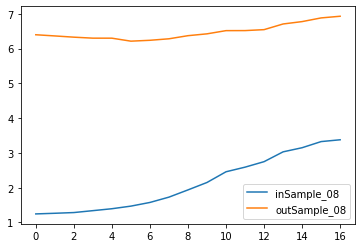

In [162]:
errors[['inSample_08', 'outSample_08']].plot()

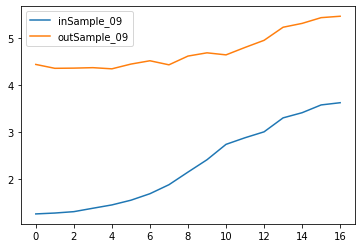

In [163]:
errors[['inSample_09', 'outSample_09']].plot()

In [145]:
errors

,weight,inSample_08,inSample_09,outSample_08,outSample_09
0,0.75,1.246196,1.252274,6.400007,4.440656
1,2.00,1.264643,1.270952,6.366042,4.357787
2,3.00,1.285294,1.300488,6.330320,4.361820
3,5.00,1.339980,1.373147,6.301920,4.371703
4,7.00,1.395298,1.444130,6.301298,4.346940
5,10.00,1.470528,1.544513,6.215503,4.448067
6,15.00,1.576057,1.683202,6.240584,4.518993
7,25.00,1.729058,1.875257,6.283787,4.432412
8,50.00,1.936900,2.144296,6.373119,4.619006
9,100.00,2.150643,2.407769,6.426228,4.688227


Tune num trees - v1

In [100]:
mod = xgb_model(num_boost_round=5, max_depth=5, eta=0.3, gpu_id=0, tree_method='gpu_hist')
xgb1 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb1.scores

Working on: 2015-09
fit time: 448.7321078777313


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,2.071636,2.577353,3.51808,4.621091


In [107]:
mod = xgb_model(num_boost_round=10, max_depth=5, eta=0.3, gpu_id=0, tree_method='gpu_hist')
xgb2 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb2.scores

Working on: 2015-09
fit time: 453.72365856170654


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.878408,2.336968,3.40445,4.488744


In [109]:
mod = xgb_model(num_boost_round=20, max_depth=5, eta=0.3, gpu_id=0, tree_method='gpu_hist')
xgb3 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb3.scores

Working on: 2015-09
fit time: 443.2325327396393


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.71654,2.135615,3.504612,4.598303


This is a decrease in OutSample performance

Tune max_depth

In [110]:
mod = xgb_model(num_boost_round=10, max_depth=10, eta=0.3, gpu_id=0, tree_method='gpu_hist')
xgb4 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb4.scores

Working on: 2015-09
fit time: 451.9696443080902


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.537542,1.903766,3.454867,4.465643


In [111]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist')
xgb5 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb5.scores

Working on: 2015-09
fit time: 467.3969130516052


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.452223,1.778487,3.374519,4.414141


In [112]:
mod = xgb_model(num_boost_round=10, max_depth=20, eta=0.3, gpu_id=0, tree_method='gpu_hist')
xgb6 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb6.scores

Working on: 2015-09
fit time: 471.0745520591736


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.399112,1.702981,3.375141,4.392479


In [113]:
mod = xgb_model(num_boost_round=10, max_depth=25, eta=0.3, gpu_id=0, tree_method='gpu_hist')
xgb7 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb7.scores

Working on: 2015-09
fit time: 597.5037202835083


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.374042,1.674943,3.443991,4.545496


Tune min_child_weight

In [69]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3)
xgb8 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb8.scores

Working on: 2015-09
fit time: 415.39419531822205


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.555581,1.905125,3.256072,4.314246


In [71]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=4)
xgb9 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb9.scores

Working on: 2015-09
fit time: 409.84160470962524


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.616427,1.981819,3.301576,4.252826


In [69]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=2)
xgb10 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb10.scores

Working on: 2015-09
fit time: 380.04951190948486


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.49811,1.832468,3.347331,4.310683


Tune gamma - v1

In [70]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3, gamma=0.1)
xgb11 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb11.scores

Working on: 2015-09
fit time: 401.9728960990906


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.558374,1.910212,3.224336,4.20106


In [71]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3, gamma=0.2)
xgb12 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb12.scores

Working on: 2015-09
fit time: 381.93823504447937


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.563509,1.913821,3.408209,4.520965


Tune colsample_bytree

In [72]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3, gamma=0.1, colsample_bytree=0.5)
xgb13 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb13.scores

Working on: 2015-09
fit time: 367.2258598804474


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.554905,1.905897,3.523711,4.475282


In [73]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3, gamma=0.1, colsample_bytree=0.25)
xgb14 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb14.scores

Working on: 2015-09
fit time: 395.63709235191345


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.570256,1.922398,3.715294,4.627332


In [74]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3, gamma=0.1, colsample_bytree=0.75)
xgb15 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb15.scores

Working on: 2015-09
fit time: 389.1943893432617


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.587069,1.946151,3.416441,4.504229


In [75]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3, gamma=0.1, colsample_bytree=0.9)
xgb16 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb16.scores

Working on: 2015-09
fit time: 425.58503127098083


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.54764,1.889438,3.576048,4.724562


In [76]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3, gamma=0.1, colsample_bytree=0.95)
xgb17 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb17.scores

Working on: 2015-09
fit time: 405.35559368133545


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.560242,1.910468,3.56527,4.611157


In [78]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3, gamma=0.1, colsample_bytree=1)
xgb18 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb18.scores

Working on: 2015-09
fit time: 400.2204647064209


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.581847,1.937094,3.624732,4.79397


In [79]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3, gamma=0.1, colsample_bytree=0.8)
xgb19 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb19.scores

Working on: 2015-09
fit time: 489.6808226108551


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.577413,1.933916,3.57007,4.713628


repeat lowest - preOutSample was 3.224336

In [80]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3, gamma=0.1)
xgb20 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb20.scores

Working on: 2015-09
fit time: 398.8595907688141


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.570103,1.922401,3.49114,4.616975


Same parms, different results: 3.224336, 3.49114  - big spread in random difference

In [81]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3, gamma=0.1, colsample_bytree=0.70)
xgb21 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb21.scores

Working on: 2015-09
fit time: 404.32211780548096


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.560746,1.912095,3.490181,4.522107


Re-tune num trees

In [82]:
mod = xgb_model(num_boost_round=15, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3, gamma=0.1, colsample_bytree=0.70)
xgb22 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb22.scores

Working on: 2015-09
fit time: 433.95582008361816


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.467228,1.793479,3.558914,4.442888


In [83]:
mod = xgb_model(num_boost_round=7, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3, gamma=0.1, colsample_bytree=0.70)
xgb23 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb23.scores

Working on: 2015-09
fit time: 394.7556836605072


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.690958,2.081592,3.543582,4.599802


Tune subsample

In [67]:
mod = xgb_model(num_boost_round=15, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.5)
xgb24 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb24.scores

Working on: 2015-09
fit time: 417.0325565338135


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.600846,1.959484,3.533276,4.664327


In [68]:
mod = xgb_model(num_boost_round=15, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.25)
xgb24 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb24.scores

Working on: 2015-09
fit time: 383.82120156288147


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.939659,2.373006,3.78051,4.943948


In [69]:
mod = xgb_model(num_boost_round=15, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.75)
xgb25 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb25.scores

Working on: 2015-09
fit time: 378.18624448776245


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.484346,1.812144,3.389474,4.395206


In [70]:
mod = xgb_model(num_boost_round=15, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85)
xgb26 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb26.scores

Working on: 2015-09
fit time: 459.5859055519104


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.452081,1.777478,3.332366,4.38954


reg alpha

In [71]:
mod = xgb_model(num_boost_round=15, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1e-2)
xgb27 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb27.scores

Working on: 2015-09
fit time: 391.82743763923645


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.466667,1.794442,3.453205,4.512323


In [72]:
mod = xgb_model(num_boost_round=15, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=0.1)
xgb28 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb28.scores

Working on: 2015-09
fit time: 396.5325367450714


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.4524,1.776852,3.320794,4.301734


In [73]:
mod = xgb_model(num_boost_round=15, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1)
xgb29 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb29.scores

Working on: 2015-09
fit time: 401.88452410697937


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.460326,1.788103,3.288492,4.296378


In [74]:
mod = xgb_model(num_boost_round=15, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=10)
xgb30 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb30.scores

Working on: 2015-09
fit time: 395.5733845233917


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.45779,1.784869,3.350702,4.380897


In [75]:
mod = xgb_model(num_boost_round=15, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=0.5)
xgb31 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb31.scores

Working on: 2015-09
fit time: 392.5182545185089


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.466542,1.79486,3.444049,4.5182


In [76]:
mod = xgb_model(num_boost_round=15, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=2)
xgb32 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb32.scores

Working on: 2015-09
fit time: 393.9164659976959


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.460489,1.789084,3.412619,4.480037


keep reg alpha at 1

In [77]:
mod = xgb_model(num_boost_round=45, max_depth=15, eta=0.1, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1)
xgb33 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb33.scores

Working on: 2015-09
fit time: 416.79675006866455


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.462329,1.790995,3.373817,4.364335


In [78]:
mod = xgb_model(num_boost_round=100, max_depth=15, eta=0.05, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1)
xgb34 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb34.scores

Working on: 2015-09
fit time: 479.00764989852905


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.438745,1.762985,3.392436,4.385812


In [79]:
mod = xgb_model(num_boost_round=150, max_depth=15, eta=0.05, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1)
xgb35 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb35.scores

Working on: 2015-09
fit time: 480.32368564605713


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.393894,1.706193,3.352824,4.311378


In [80]:
mod = xgb_model(num_boost_round=300, max_depth=15, eta=0.025, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1)
xgb36 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb36.scores

Working on: 2015-09
fit time: 578.7205331325531


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.393748,1.705426,3.317894,4.312685


In [81]:
mod = xgb_model(num_boost_round=400, max_depth=15, eta=0.025, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1)
xgb37 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb37.scores

Working on: 2015-09
fit time: 654.8986668586731


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.373772,1.679657,3.390463,4.385338


In [83]:
mod = xgb_model(num_boost_round=800, max_depth=15, eta=0.01, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1)
xgb38 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb38.scores

Working on: 2015-09
fit time: 930.6585764884949


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.387192,1.697351,3.406284,4.393435


In [84]:
mod = xgb_model(num_boost_round=1000, max_depth=15, eta=0.01, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1)
xgb39 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb39.scores

Working on: 2015-09
fit time: 1071.7277617454529


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.372758,1.678388,3.411441,4.405141


In [85]:
mod = xgb_model(num_boost_round=1000, max_depth=20, eta=0.01, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1)
xgb40 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb40.scores

Working on: 2015-09
fit time: 2256.491931438446


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.329592,1.618455,3.44159,4.423015


Stack more months

In [86]:
mod = xgb_model(num_boost_round=300, max_depth=15, eta=0.025, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1)
xgb41 = rolling_cross_validation(mod, months[16:], num_lagged_values=0, num_stack_months=16, fit_final=False)
xgb41.scores

Working on: 2015-09
fit time: 770.0432236194611


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.302002,1.566265,3.324735,4.341179


# Final Model

In [183]:
mod = xgb_model(num_boost_round=300, max_depth=15, eta=0.025, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1, seed=42)
xgbFinal = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgbFinal.scores

Working on: 2015-08
fit time: 147.2652781009674
Working on: 2015-09
fit time: 145.10959839820862


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.382010,1.382010,6.401488,6.401488
2015-09,1.394835,1.394835,4.255646,4.255646


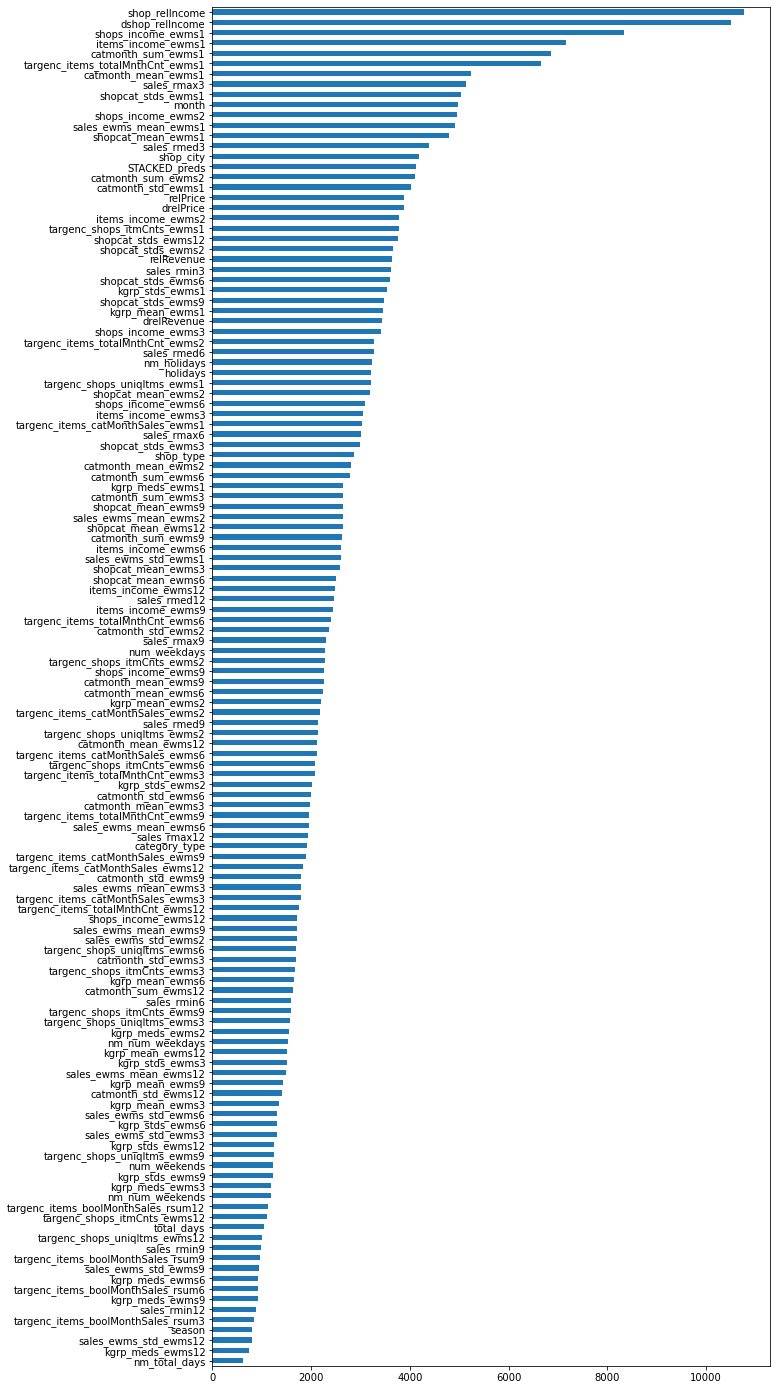

In [184]:
res = plot_feature_importances(xgbFinal.fitted_models[months[-2]], figsize=(10,25))
#plt.savefig('Top20.png', bbox_inches='tight')

In [174]:
mod = xgb_model(num_boost_round=300, max_depth=15, eta=0.025, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1, seed=42)
xgbFinal = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgbFinal.scores

Working on: 2015-08
fit time: 144.70071578025818
Working on: 2015-09
fit time: 141.12069463729858


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.389766,1.389766,6.324535,6.324535
2015-09,1.391322,1.391322,4.431172,4.431172


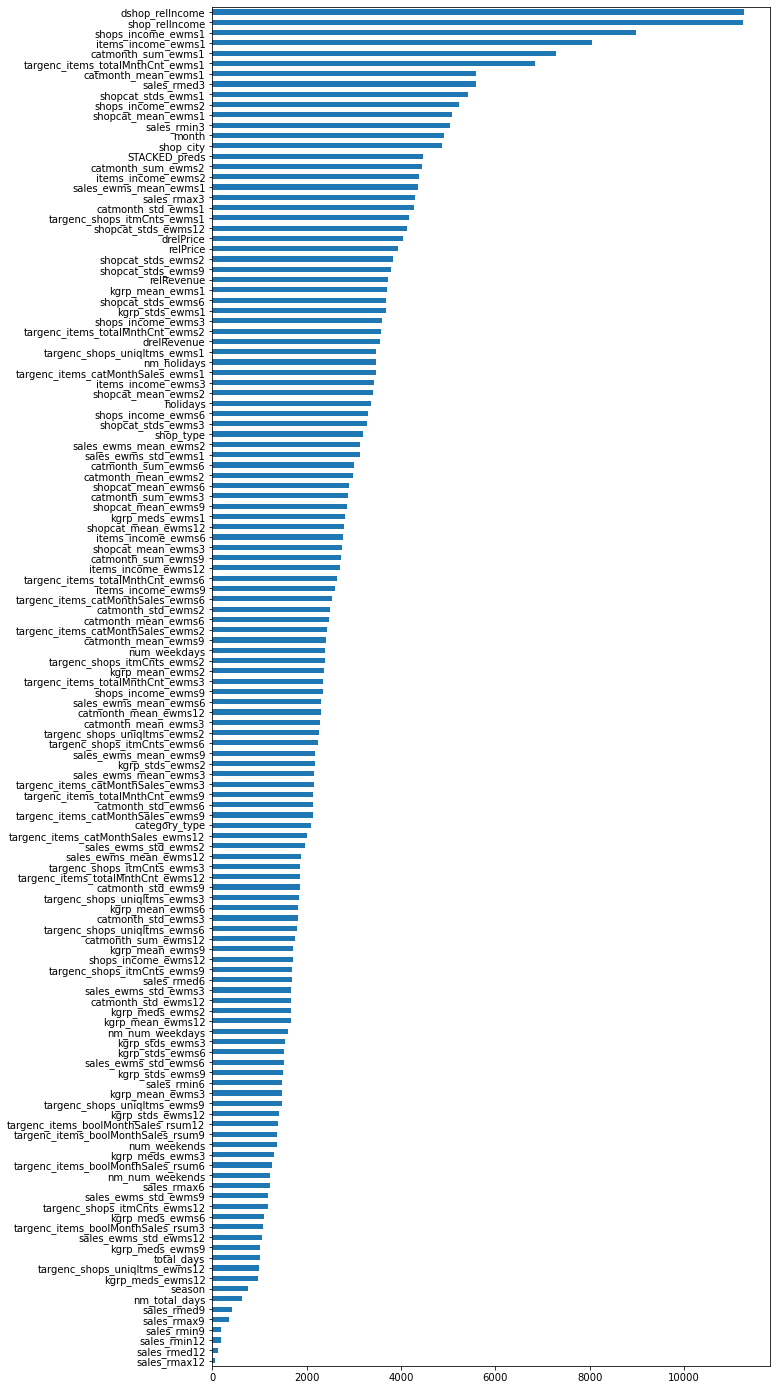

In [176]:
res = plot_feature_importances(xgbFinal.fitted_models[months[-2]], figsize=(10,25))
#plt.savefig('Top20.png', bbox_inches='tight')

In [151]:
mod = xgb_model(num_boost_round=300, max_depth=15, eta=0.025, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1, seed=42)
xgbFinal = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=False, reindex_to_sub=True)
xgbFinal.scores

Working on: 2015-08
fit time: 201.97389698028564
Working on: 2015-09
fit time: 136.5059552192688


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.382203,1.382203,6.284645,6.284645
2015-09,1.405284,1.405284,4.564302,4.564302


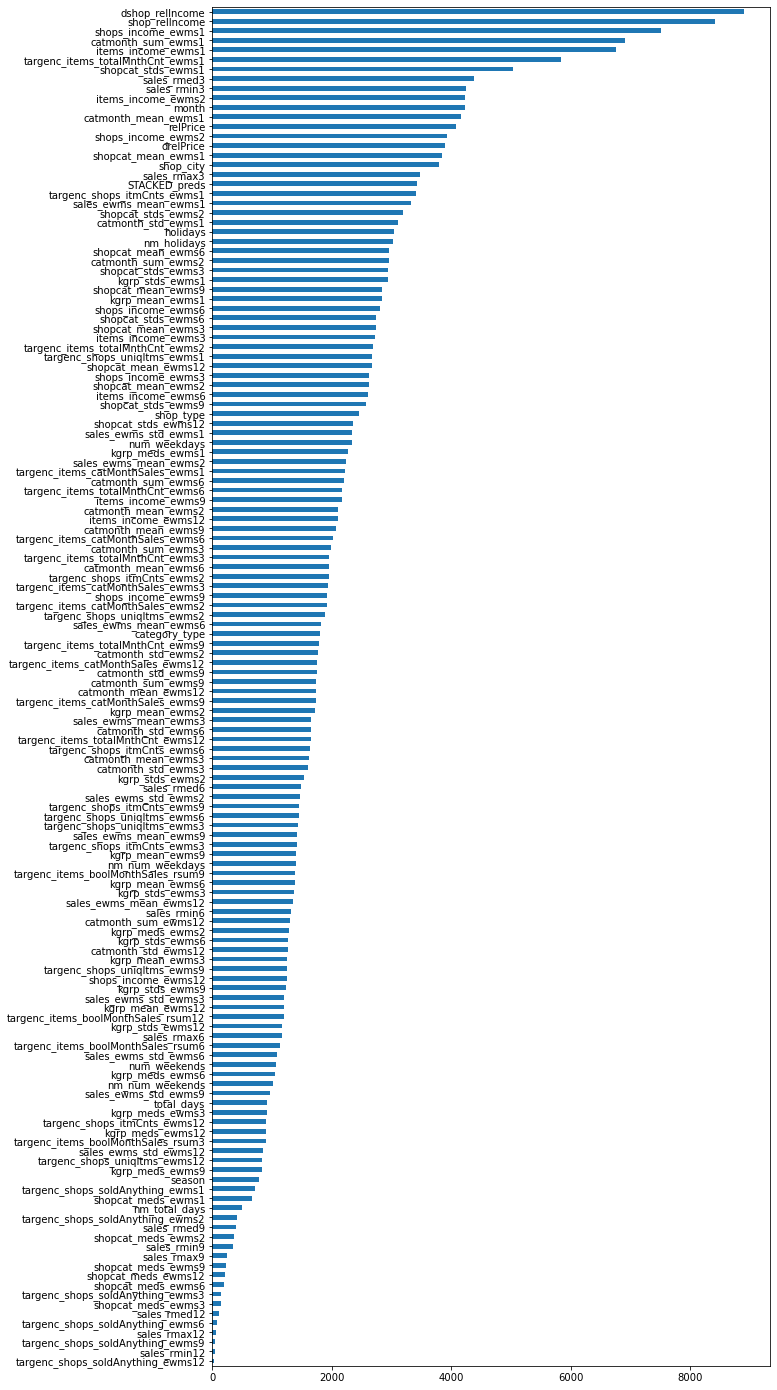

In [172]:
res = plot_feature_importances(xgbFinal.fitted_models[months[-2]], figsize=(10,25))
#plt.savefig('Top20.png', bbox_inches='tight')

In [138]:
mod = xgb_model(num_boost_round=300, max_depth=15, eta=0.025, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1, seed=42)
xgbFinal = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=True, reindex_to_sub=True)
xgbFinal.scores

Working on: 2015-08
fit time: 501.04605770111084
Working on: 2015-09
fit time: 469.58700251579285


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.380758,1.380758,6.278468,6.278468
2015-09,1.393645,1.393645,4.631630,4.631630
FINAL,1.442308,1.442308,NaN,NaN


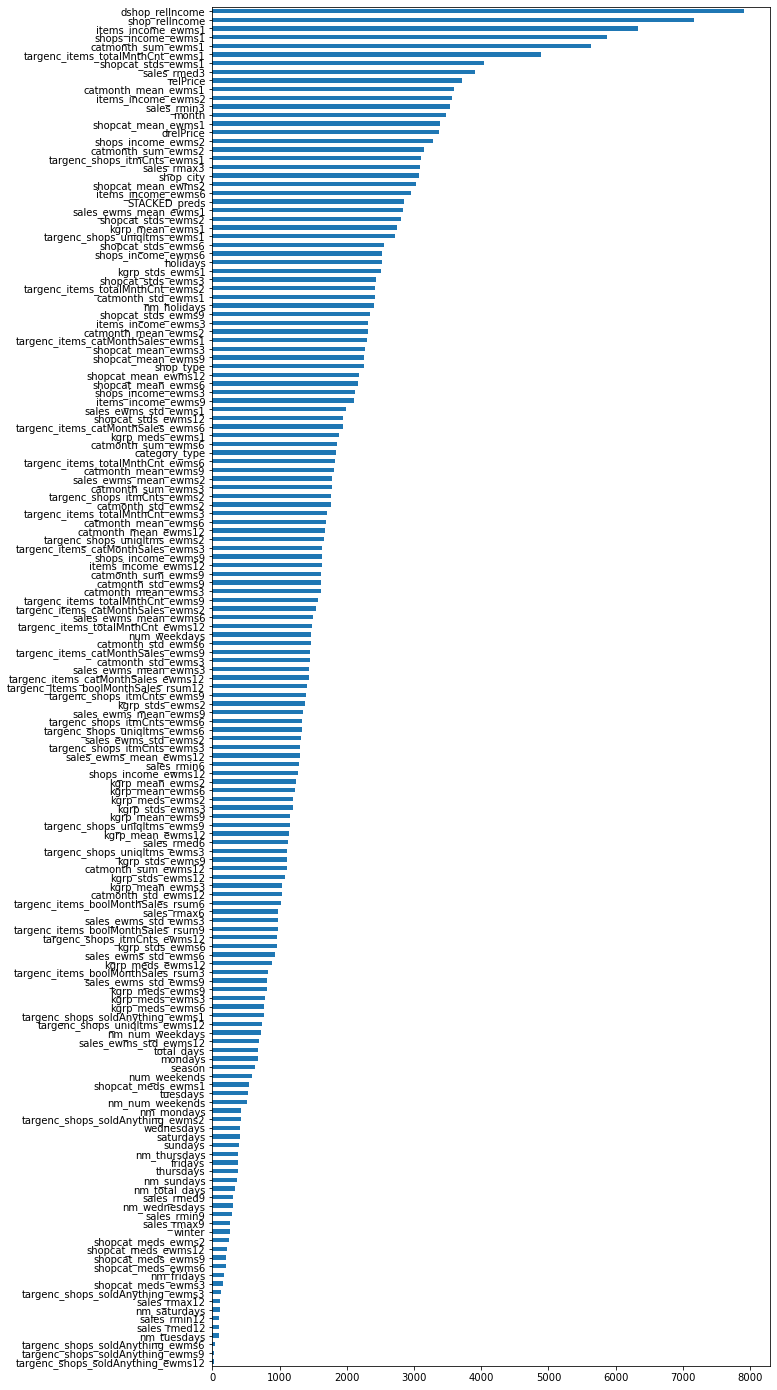

In [141]:
res = plot_feature_importances(xgbFinal.fitted_models['FINAL'], figsize=(10,25))
#plt.savefig('Top20.png', bbox_inches='tight')

In [136]:
mod = xgb_model(num_boost_round=300, max_depth=15, eta=0.025, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1, seed=42)
xgbFinal = rolling_cross_validation(mod, months[18:], num_lagged_values=0, num_stack_months=13, fit_final=False, reindex_to_sub=True)
xgbFinal.scores

Working on: 2015-08
fit time: 253.6264989376068
Working on: 2015-09
fit time: 254.3666913509369


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.540285,1.540285,6.299746,6.299746
2015-09,1.577306,1.577306,4.363626,4.363626


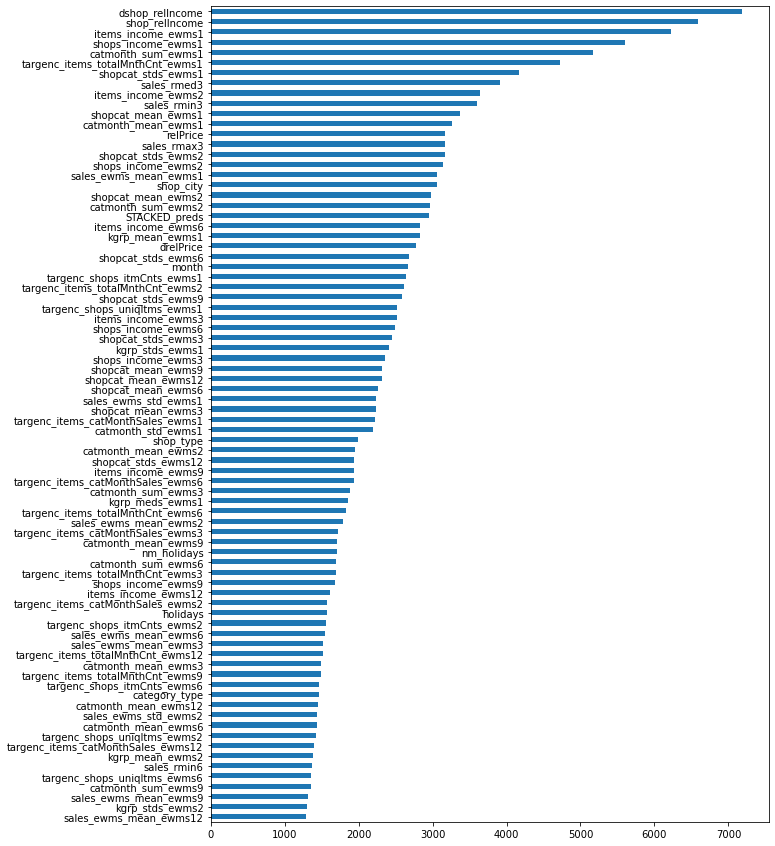

In [137]:
res = plot_feature_importances(xgbFinal.fitted_models[months[-2]], top_n=80, figsize=(10,15))
#plt.savefig('Top20.png', bbox_inches='tight')

In [103]:
mod = xgb_model(num_boost_round=300, max_depth=15, eta=0.025, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1, seed=42)
xgbFinal = rolling_cross_validation(mod, months[18:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgbFinal.scores

Working on: 2015-08
fit time: 492.6684777736664
Working on: 2015-09
fit time: 461.96549439430237


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-08,1.474159,1.742003,4.769532,6.329624
2015-09,1.483185,1.772296,3.584820,4.404813


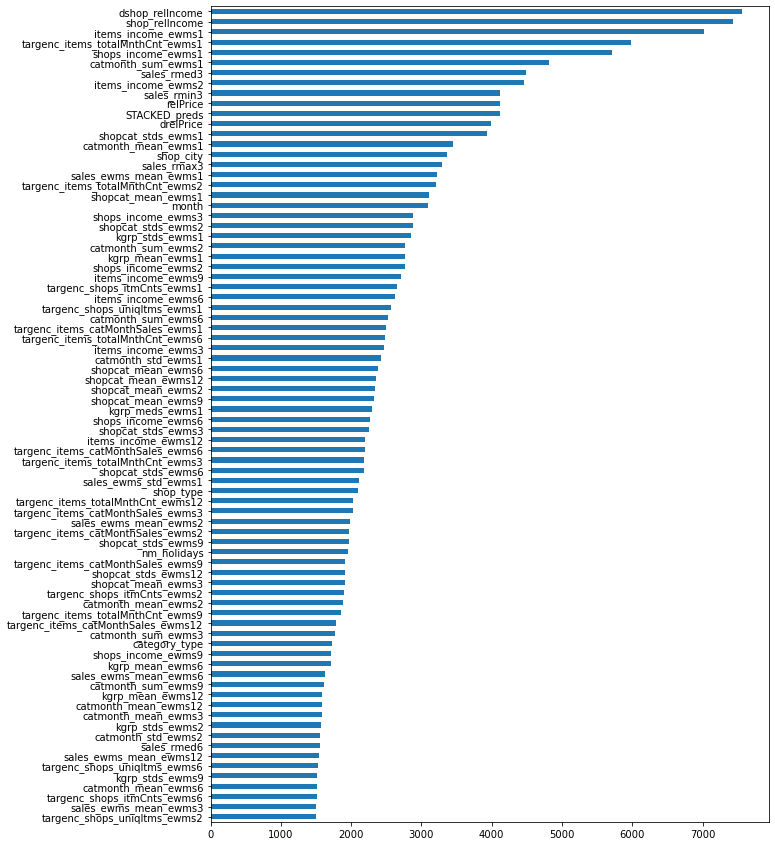

In [105]:
res = plot_feature_importances(xgbFinal.fitted_models[months[-2]], top_n=80, figsize=(10,15))
#plt.savefig('Top20.png', bbox_inches='tight')

In [131]:
mod = xgb_model(num_boost_round=500, max_depth=15, eta=0.025, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1, seed=42)
xgbFinal = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=True)
xgbFinal.scores

Working on: 2015-09
fit time: 672.6402862071991


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.365892,1.658113,3.40689,4.35554
FINAL,1.336040,1.638244,NaN,NaN


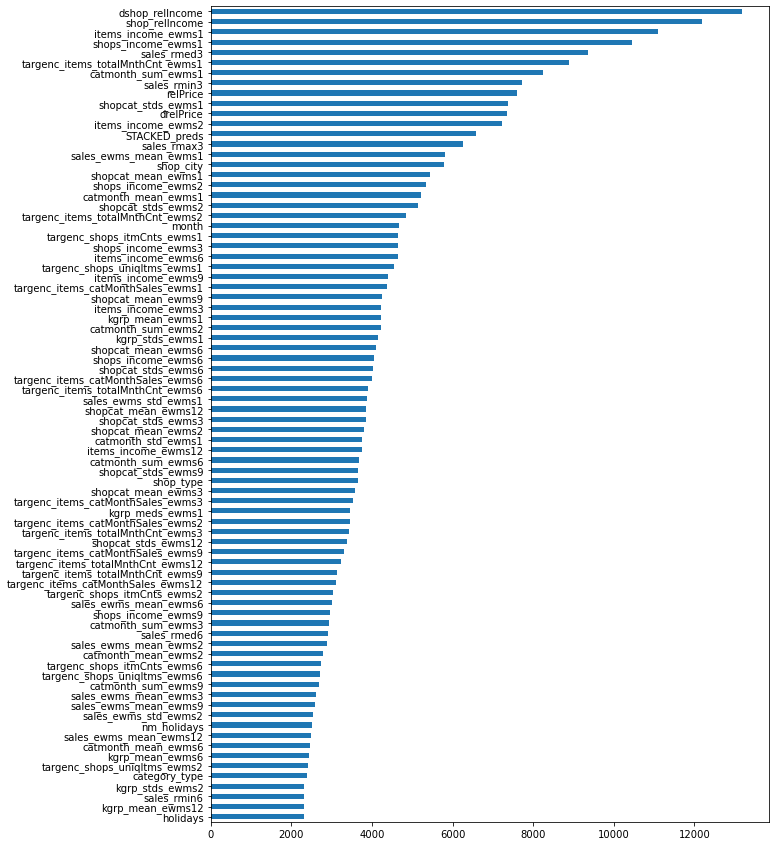

In [132]:
res = plot_feature_importances(xgbFinal.fitted_models['FINAL'], top_n=80, figsize=(10,15))
#plt.savefig('Top20.png', bbox_inches='tight')

In [128]:
mod = xgb_model(num_boost_round=300, max_depth=15, eta=0.025, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1, seed=42)
xgbFinal = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=True)
xgbFinal.scores

Working on: 2015-09
fit time: 572.2775461673737


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.400427,1.701810,3.348808,4.26207
FINAL,1.376824,1.690106,NaN,NaN


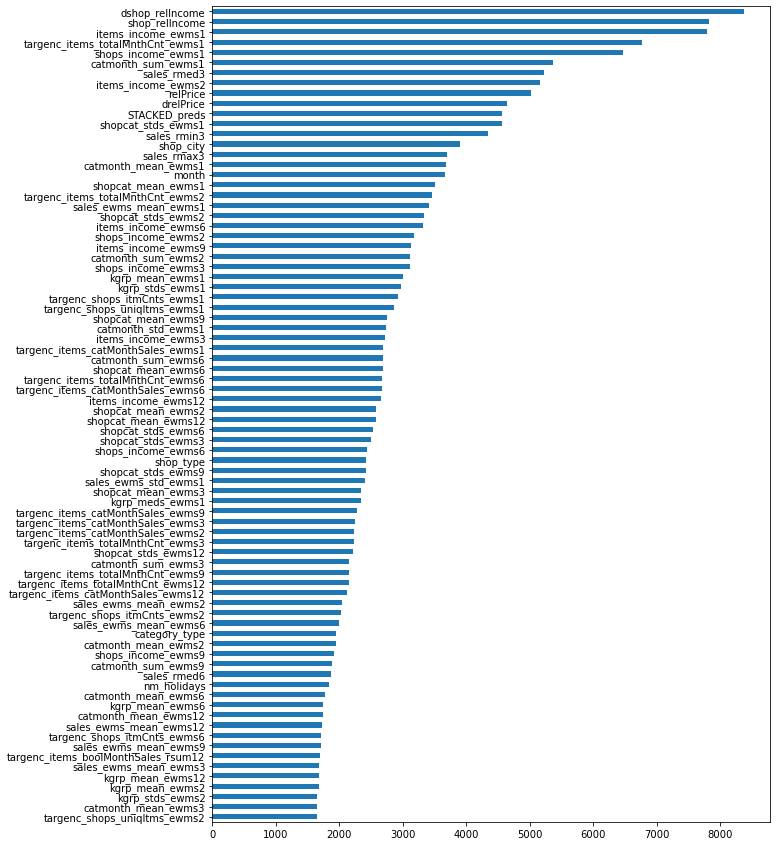

In [130]:
res = plot_feature_importances(xgbFinal.fitted_models['FINAL'], top_n=80, figsize=(10,15))
#plt.savefig('Top20.png', bbox_inches='tight')

In [100]:
mod = xgb_model(num_boost_round=300, max_depth=15, eta=0.025, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1, seed=42)
xgbFinal = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=True)
xgbFinal.scores

Working on: 2015-09
fit time: 589.1227111816406


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.398492,1.698835,3.393748,4.31229
FINAL,1.380738,1.695190,NaN,NaN


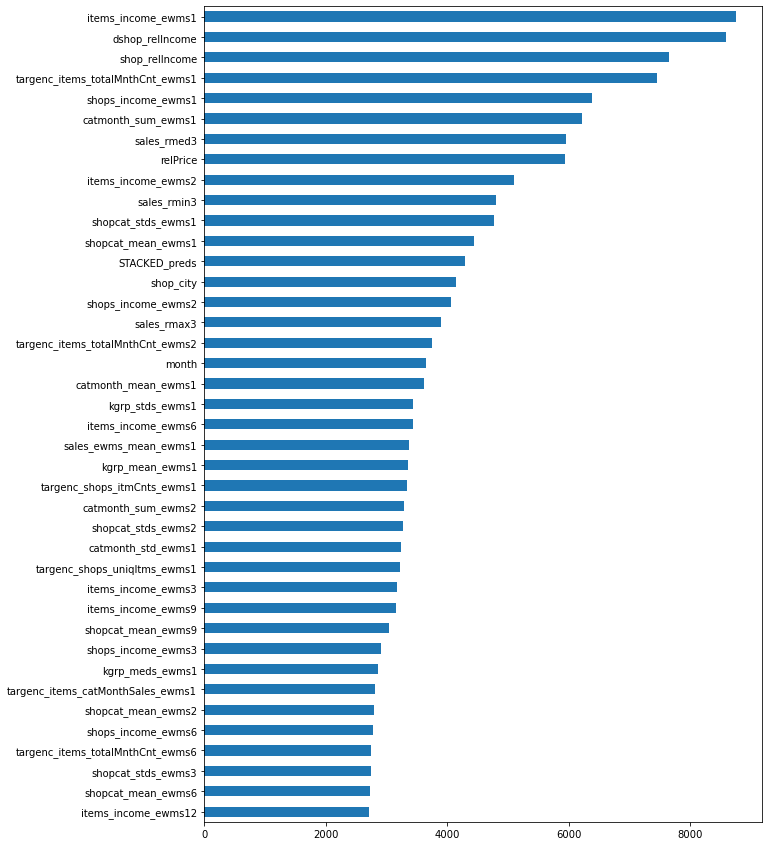

In [101]:
res = plot_feature_importances(xgbFinal.fitted_models['FINAL'], top_n=40, figsize=(10,15))
#plt.savefig('Top20.png', bbox_inches='tight')

In [98]:
mod = xgb_model(num_boost_round=300, max_depth=15, eta=0.025, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1)
xgbFinal = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=True)
xgbFinal.scores

Working on: 2015-09
fit time: 557.8302907943726


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.396945,1.698046,3.391637,4.28098
FINAL,1.385327,1.701591,NaN,NaN


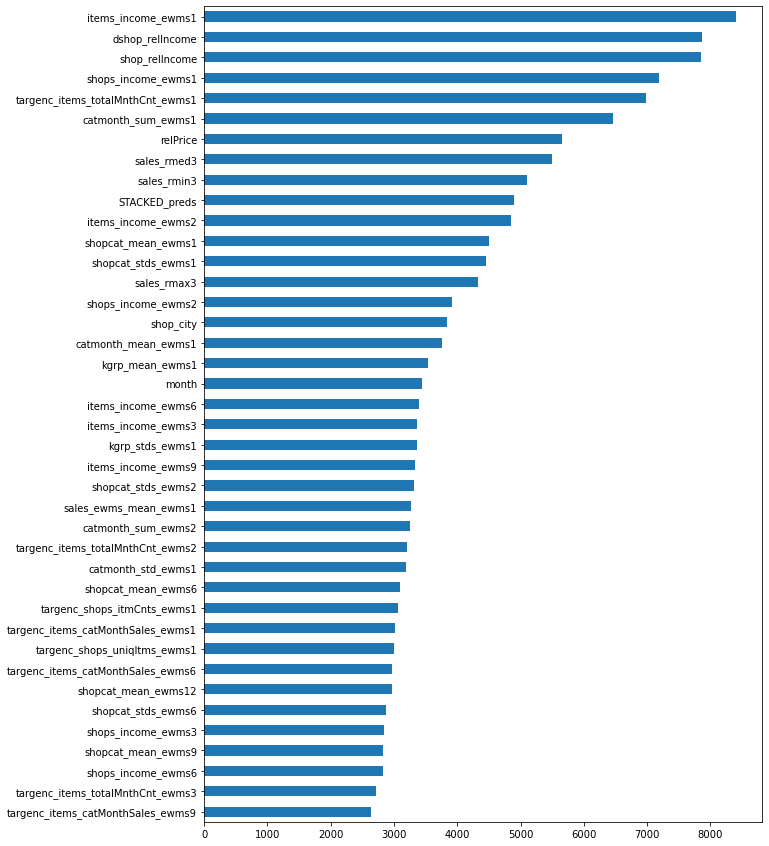

In [99]:
res = plot_feature_importances(xgbFinal.fitted_models['FINAL'], top_n=40, figsize=(10,15))
#plt.savefig('Top20.png', bbox_inches='tight')

In [78]:
mod = xgb_model(num_boost_round=300, max_depth=15, eta=0.025, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1)
xgbFinal = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=True)
xgbFinal.scores

Working on: 2015-09
fit time: 547.1211247444153


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.400357,1.702079,3.396775,4.323409
FINAL,1.385859,1.703105,NaN,NaN


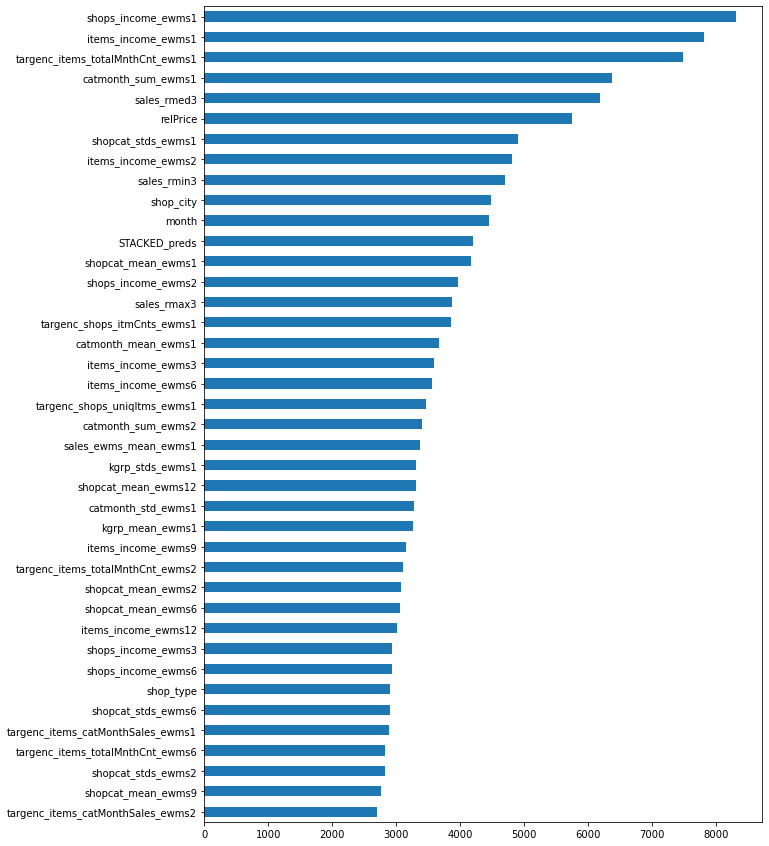

In [79]:
res = plot_feature_importances(xgbFinal.fitted_models['FINAL'], top_n=40, figsize=(10,15))
#plt.savefig('Top20.png', bbox_inches='tight')

In [123]:
mod = xgb_model(num_boost_round=300, max_depth=15, eta=0.025, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1)
xgbFinal = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=True)
xgbFinal.scores

Working on: 2015-09
fit time: 643.6349017620087


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.399950,1.702693,3.430254,4.386861
FINAL,1.374683,1.689325,NaN,NaN


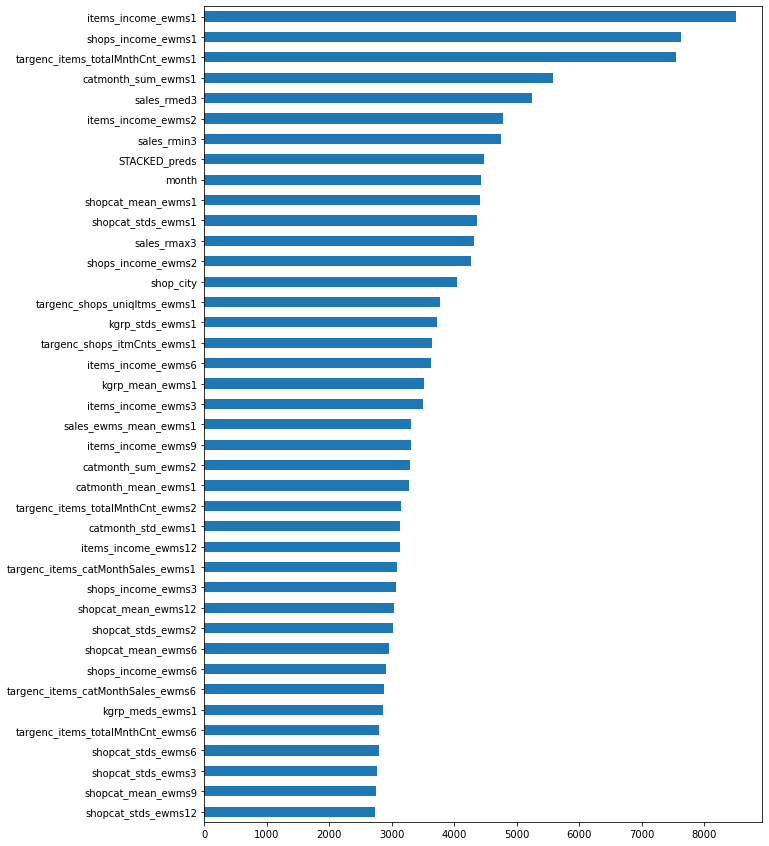

In [127]:
res = plot_feature_importances(xgbFinal.fitted_models['FINAL'], top_n=40, figsize=(10,15))
#plt.savefig('Top20.png', bbox_inches='tight')

In [ ]:
# model = XGBRegressor(
#     max_depth=10,
#     n_estimators=1000,
#     min_child_weight=0.5, 
#     colsample_bytree=0.8, 
#     subsample=0.8, 
#     eta=0.1,
#     tree_method='gpu_hist',
#     seed=42)

# model.fit(
#     X_train, 
#     Y_train, 
#     eval_metric="rmse", 
#     eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
#     verbose=True, 
#     early_stopping_rounds = 20)

# time.time() - ts

In [70]:
mod = xgb_model(num_boost_round=300, max_depth=15, eta=0.025, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1)
xgbFinal = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=True)
xgbFinal.scores

Working on: 2015-09
fit time: 573.8778414726257


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.390869,1.701459,3.346659,4.301463
FINAL,1.368414,1.691437,NaN,NaN


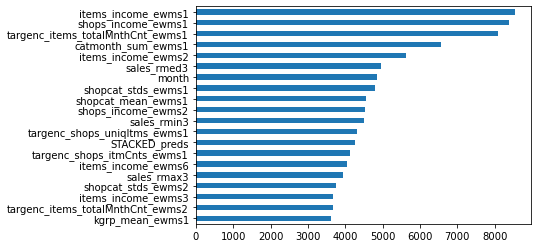

In [83]:
res = plot_feature_importances(xgbFinal.fitted_models['FINAL'], top_n=20)
plt.savefig('Top20.png', bbox_inches='tight')

In [99]:
mod = xgb_model(num_boost_round=300, max_depth=15, eta=0.025, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1)
xgbFinal = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=True)
xgbFinal.scores

Working on: 2015-09
fit time: 141.9971854686737


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.477865,1.766114,1.840005,2.067088
FINAL,1.442412,1.737651,NaN,NaN


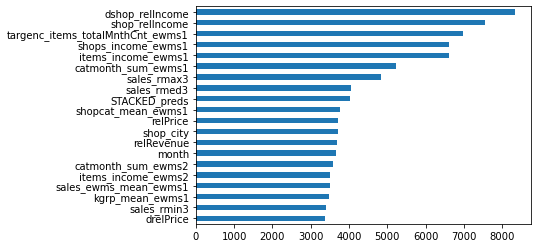

In [100]:
res = plot_feature_importances(xgbFinal.fitted_models['FINAL'], top_n=20)
plt.savefig('Top20.png', bbox_inches='tight')

# Preparing Submission

In [101]:
def merge_pred_with_test(prediction, fill_val=0, pred_col='item_cnt_month'):
    assert pred_col in prediction.columns, f'Couldnt find {pred_col}'
    data_fol = 'data'
    test = pd.read_csv(os.path.join(data_fol, 'test.csv'))
    merged =  pd.merge(test, prediction, on=['shop_id', 'item_id'], how='left').fillna(fill_val)
    if pred_col != 'item_cnt_month':
        merged = merged.rename(columns={pred_col:'item_cnt_month'})
    return merged.set_index('ID')['item_cnt_month']

In [102]:
Xt, Yt, _ = get_single_month_XY(months[-1])

In [103]:
y_pred = pd.DataFrame({'item_cnt_month':xgbFinal.fitted_models['FINAL'].predict(Xt)}, index=Xt.index)
y_sub = merge_pred_with_test(y_pred)

In [126]:
y_pred = pd.DataFrame({'item_cnt_month':xgbFinal.fitted_models[months[-2]].predict(Xt)}, index=Xt.index)
y_sub = merge_pred_with_test(y_pred)

In [127]:
y_sub.to_csv('xgbFinal.csv')

In [128]:
np.clip(0, 15, y_sub).to_csv('xgbFinal_clipped15.csv')

In [129]:
np.clip(0, 20, y_sub).to_csv('xgbFinal_clipped20.csv')

# Storing model

In [89]:
import pickle

In [90]:
model = xgbFinal.fitted_models['FINAL'].fitted_model

In [91]:
pickle.dump(model, open("final_xgboost_model.p", "wb"))

# TODO
* remove shops that only sold something in the first 12 months (dont help fitting at all)
    * perhaps find a way to subset shops further
* add the category lexical parsing
* shop_type/category_type interaction
* early stopping style fitting?